## Setup

In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.layers import *

%matplotlib inline

In [2]:
import os.path

IMAGE_SIZE = 28
PIXEL_COUNT = IMAGE_SIZE ** 2

_cache = {}

def load_images(name, labels=False, sample=None):
    path = os.path.join('..', 'input', name + '.csv')
    vectors = _cache.get(path)
    
    if vectors is None:
        vectors = _cache[path] = pd.read_csv(path).as_matrix()
    
    if sample is not None:
        vectors = vectors[:sample]

    if labels:
        label_vector = vectors[:, 0]
        vectors = vectors[:, 1:]
    else:
        label_vector = None

    images = vectors.reshape(len(vectors), 1, IMAGE_SIZE, IMAGE_SIZE)
    return label_vector, images

In [3]:
def display_images(images, labels):
    figure = plt.figure(figsize=(12, 24))
    images = np.squeeze(images, axis=1)
    
    for i, (label, image) in enumerate(zip(labels, images)):
        image_plot = figure.add_subplot(1, len(images), i + 1)
        image_plot.set_title(label, fontsize=18)
        image_plot.imshow(image, interpolation=None, cmap='gray')

In [4]:
def split_data(data, labels, ratio=0.2):
    rows = data.shape[0]
    validation_indices = np.random.choice(rows, int(rows * ratio), replace=False)
    validation_mask = np.zeros(rows, np.bool)
    validation_mask[validation_indices] = True
    
    validation_data = data[validation_mask]
    validation_labels = labels[validation_mask]
    train_data = data[~validation_mask]
    train_labels = labels[~validation_mask]
    
    return train_labels, train_data, validation_labels, validation_data

In [5]:
import math
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

noop_generator = ImageDataGenerator()

def fit(model, train_in, train_out, val_in, val_out, lr=0.001, gen=noop_generator):
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy'],
    )
    runs = [(lr, 5), (lr * 10, 10), (lr, 5)]
    
    train_gen = gen.flow(train_in, to_categorical(train_out), batch_size=32)
    val_gen = noop_generator.flow(val_in, to_categorical(val_out), batch_size=32, shuffle=False)
    
    for lr, epochs in runs:
        model.optimizer.lr = lr
        model.fit_generator(
            train_gen,
            steps_per_epoch=math.ceil(train_in.shape[0] / 32),
            validation_data=val_gen,
            validation_steps=math.ceil(val_in.shape[0] / 32),
            epochs=epochs,
        )
        
    out = model.predict_classes(val_in, batch_size=32)
    errors = np.where(out != val_out)[0][:5]
    display_images(val_in[errors], out[errors])

## Load images

(1000,)

(1000, 1, 28, 28)

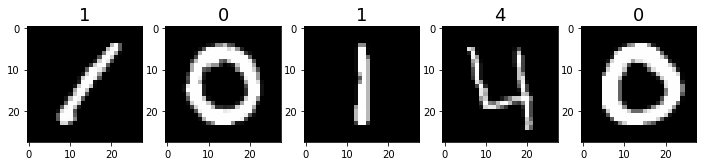

In [6]:
labels, images = load_images('train', labels=True, sample=1000)
display(labels.shape)
display(images.shape)
display_images(images[:5], labels[:5])

(800,)

(800, 1, 28, 28)

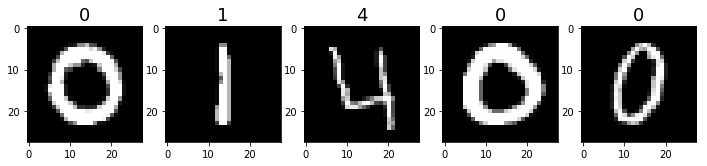

In [7]:
train_labels, train_images, val_labels, val_images = split_data(images, labels)

display(train_labels.shape)
display(train_images.shape)
display_images(train_images[:5], train_labels[:5])

(200,)

(200, 1, 28, 28)

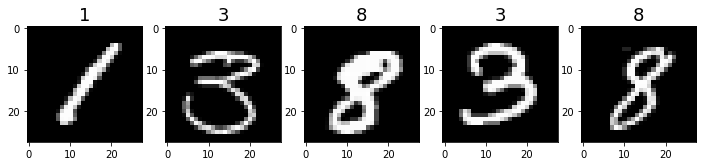

In [8]:
display(val_labels.shape)
display(val_images.shape)
display_images(val_images[:5], val_labels[:5])

## Simple model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input

simple = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_2 (Activation)    (None, 10)                0         
Total params: 25,450
Trainable params: 25,450
Non-trainable params: 0
_________________________________________________________________


Epoch 1/5
25/25 [==============================] - 0s - loss: 13.2090 - acc: 0.1712 - val_loss: 12.4946 - val_acc: 0.2150
Epoch 2/5
25/25 [==============================] - 0s - loss: 12.5030 - acc: 0.2150 - val_loss: 12.4985 - val_acc: 0.2200
Epoch 3/5
25/25 [==============================] - 0s - loss: 12.3446 - acc: 0.2300 - val_loss: 12.5869 - val_acc: 0.2150
Epoch 4/5
25/25 [==============================] - 0s - loss: 11.8757 - acc: 0.2587 - val_loss: 11.6981 - val_acc: 0.2700
Epoch 5/5
25/25 [==============================] - 0s - loss: 11.6176 - acc: 0.2750 - val_loss: 11.6856 - val_acc: 0.2750
Epoch 1/10
25/25 [==============================] - 0s - loss: 11.2046 - acc: 0.2950 - val_loss: 11.6054 - val_acc: 0.2800
Epoch 2/10
25/25 [==============================] - 0s - loss: 11.0362 - acc: 0.3112 - val_loss: 11.3682 - val_acc: 0.2900
Epoch 3/10
25/25 [==============================] - 0s - loss: 10.2289 - acc: 0.3550 - val_loss: 10.5504 - val_acc: 0.3350
Epoch 4/10
25/25 [===

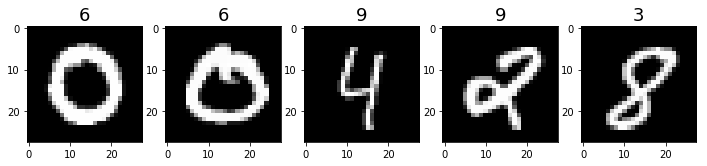

In [11]:
fit(simple, train_images, train_labels, val_images, val_labels)

## Simple + BatchNorm

In [12]:
from keras.layers import BatchNormalization

simple_bn = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple_bn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 784)               3136      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 10)                330       
_________________________________________________________________
activation_4 (Activation)    (None, 10)                0         
Total para

Epoch 1/5
25/25 [==============================] - 0s - loss: 1.8031 - acc: 0.4150 - val_loss: 1.3700 - val_acc: 0.6300
Epoch 2/5
25/25 [==============================] - 0s - loss: 0.8671 - acc: 0.7650 - val_loss: 0.9401 - val_acc: 0.7600
Epoch 3/5
25/25 [==============================] - 0s - loss: 0.6329 - acc: 0.8425 - val_loss: 0.8077 - val_acc: 0.8050
Epoch 4/5
25/25 [==============================] - 0s - loss: 0.5157 - acc: 0.8800 - val_loss: 0.7612 - val_acc: 0.8300
Epoch 5/5
25/25 [==============================] - 0s - loss: 0.4041 - acc: 0.9088 - val_loss: 0.7353 - val_acc: 0.8350
Epoch 1/10
25/25 [==============================] - 0s - loss: 0.3525 - acc: 0.9250 - val_loss: 0.7207 - val_acc: 0.8350
Epoch 2/10
25/25 [==============================] - 0s - loss: 0.2966 - acc: 0.9375 - val_loss: 0.7452 - val_acc: 0.8250
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.2649 - acc: 0.9600 - val_loss: 0.7573 - val_acc: 0.8250
Epoch 4/10
25/25 [===================

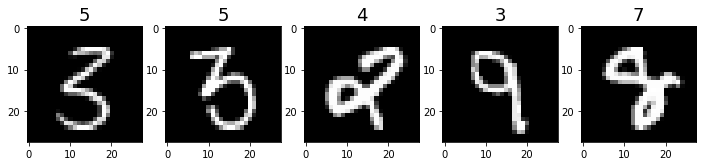

In [13]:
fit(simple_bn, train_images, train_labels, val_images, val_labels)

## Simple + Data Augumentation

In [37]:
# same as simple_bn
simple_aug = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=(0.9, 1.2),
    data_format='channels_first',
)

simple_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_12 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_27 (Batc (None, 784)               3136      
_________________________________________________________________
dense_29 (Dense)             (None, 32)                25120     
_________________________________________________________________
activation_29 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_28 (Batc (None, 32)                128       
_________________________________________________________________
dense_30 (Dense)             (None, 10)                330       
_________________________________________________________________
activation_30 (Activation)   (None, 10)                0         
Total para

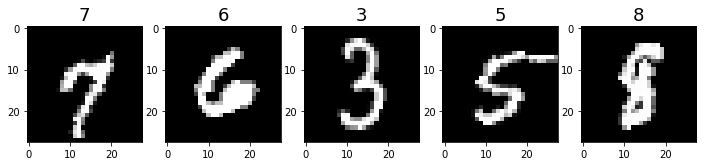

In [38]:
aug_images, aug_labels = next(aug.flow(train_images, train_labels, batch_size=5))
display_images(aug_images, aug_labels)

Epoch 1/5
25/25 [==============================] - 0s - loss: 2.0470 - acc: 0.3275 - val_loss: 2.7172 - val_acc: 0.3150
Epoch 2/5
25/25 [==============================] - 0s - loss: 1.2051 - acc: 0.6462 - val_loss: 1.6660 - val_acc: 0.4750
Epoch 3/5
25/25 [==============================] - 0s - loss: 0.9415 - acc: 0.7388 - val_loss: 1.2021 - val_acc: 0.6600
Epoch 4/5
25/25 [==============================] - 0s - loss: 0.7993 - acc: 0.7587 - val_loss: 1.0149 - val_acc: 0.7150
Epoch 5/5
25/25 [==============================] - 0s - loss: 0.6752 - acc: 0.8150 - val_loss: 0.8328 - val_acc: 0.7950
Epoch 1/10
25/25 [==============================] - 0s - loss: 0.6297 - acc: 0.8375 - val_loss: 0.7303 - val_acc: 0.8150
Epoch 2/10
25/25 [==============================] - 0s - loss: 0.5794 - acc: 0.8525 - val_loss: 0.7042 - val_acc: 0.8250
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.5445 - acc: 0.8400 - val_loss: 0.6779 - val_acc: 0.8550
Epoch 4/10
25/25 [===================

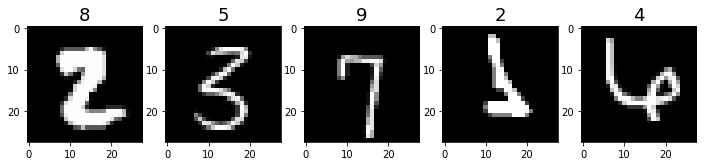

In [39]:
fit(simple_aug, train_images, train_labels, val_images, val_labels, gen=aug)

## Simple + Dropout

In [16]:
from keras.layers import Dropout

simple_do = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.5),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

simple_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 784)               3136      
_________________________________________________________________
dense_7 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_7 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                330       
__________

Epoch 1/5
25/25 [==============================] - 0s - loss: 2.3709 - acc: 0.2687 - val_loss: 2.0026 - val_acc: 0.4850
Epoch 2/5
25/25 [==============================] - 0s - loss: 1.4289 - acc: 0.5337 - val_loss: 1.2398 - val_acc: 0.6750
Epoch 3/5
25/25 [==============================] - 0s - loss: 1.0845 - acc: 0.6600 - val_loss: 1.0022 - val_acc: 0.7450
Epoch 4/5
25/25 [==============================] - 0s - loss: 0.9752 - acc: 0.7075 - val_loss: 0.8951 - val_acc: 0.7650
Epoch 5/5
25/25 [==============================] - 0s - loss: 0.8595 - acc: 0.7200 - val_loss: 0.8284 - val_acc: 0.7850
Epoch 1/10
25/25 [==============================] - 0s - loss: 0.7884 - acc: 0.7475 - val_loss: 0.8265 - val_acc: 0.8000
Epoch 2/10
25/25 [==============================] - 0s - loss: 0.6705 - acc: 0.7937 - val_loss: 0.8016 - val_acc: 0.8150
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.6326 - acc: 0.8125 - val_loss: 0.7857 - val_acc: 0.8000
Epoch 4/10
25/25 [===================

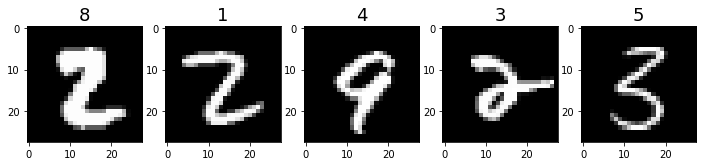

In [17]:
fit(simple_do, train_images, train_labels, val_images, val_labels)

## Hidden

In [18]:
hidden = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Hidden layer
    Dense(16),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

hidden.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 784)               3136      
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
activation_9 (Activation)    (None, 32)                0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_10 (Activation)   (None, 16)                0         
__________

Epoch 1/5
25/25 [==============================] - 0s - loss: 2.1598 - acc: 0.2337 - val_loss: 3.7827 - val_acc: 0.1950
Epoch 2/5
25/25 [==============================] - 0s - loss: 1.3521 - acc: 0.6138 - val_loss: 2.2395 - val_acc: 0.3100
Epoch 3/5
25/25 [==============================] - 0s - loss: 1.0982 - acc: 0.7263 - val_loss: 1.7047 - val_acc: 0.4900
Epoch 4/5
25/25 [==============================] - 0s - loss: 0.8971 - acc: 0.8137 - val_loss: 1.4380 - val_acc: 0.6200
Epoch 5/5
25/25 [==============================] - 0s - loss: 0.7412 - acc: 0.8675 - val_loss: 1.2690 - val_acc: 0.7100
Epoch 1/10
25/25 [==============================] - 0s - loss: 0.6185 - acc: 0.9000 - val_loss: 1.1552 - val_acc: 0.7450
Epoch 2/10
25/25 [==============================] - 0s - loss: 0.5297 - acc: 0.9175 - val_loss: 1.0603 - val_acc: 0.7750
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.4630 - acc: 0.9113 - val_loss: 1.0270 - val_acc: 0.8000
Epoch 4/10
25/25 [===================

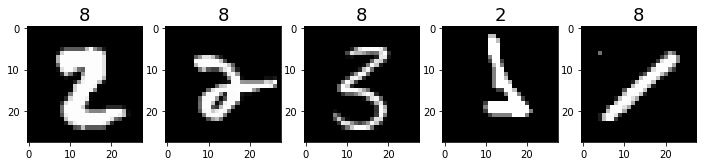

In [19]:
fit(hidden, train_images, train_labels, val_images, val_labels)

## Hidden + Dropout

In [20]:
hidden_do = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Hidden layer
    Dense(16),
    Activation('relu'),
    BatchNormalization(),
    Dropout(0.25),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

hidden_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 784)               3136      
_________________________________________________________________
dense_12 (Dense)             (None, 32)                25120     
_________________________________________________________________
activation_12 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 16)                528       
__________

Epoch 1/5
25/25 [==============================] - 0s - loss: 2.3295 - acc: 0.2137 - val_loss: 2.2506 - val_acc: 0.2550
Epoch 2/5
25/25 [==============================] - 0s - loss: 1.7206 - acc: 0.4225 - val_loss: 1.7645 - val_acc: 0.3900
Epoch 3/5
25/25 [==============================] - 0s - loss: 1.4896 - acc: 0.4950 - val_loss: 1.5083 - val_acc: 0.5900
Epoch 4/5
25/25 [==============================] - 0s - loss: 1.3291 - acc: 0.5800 - val_loss: 1.3656 - val_acc: 0.6800
Epoch 5/5
25/25 [==============================] - 0s - loss: 1.1870 - acc: 0.6438 - val_loss: 1.2639 - val_acc: 0.7100
Epoch 1/10
25/25 [==============================] - 0s - loss: 1.0406 - acc: 0.6938 - val_loss: 1.1482 - val_acc: 0.7650
Epoch 2/10
25/25 [==============================] - 0s - loss: 1.0000 - acc: 0.7238 - val_loss: 1.0895 - val_acc: 0.7700
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.8605 - acc: 0.7838 - val_loss: 1.0382 - val_acc: 0.7800
Epoch 4/10
25/25 [===================

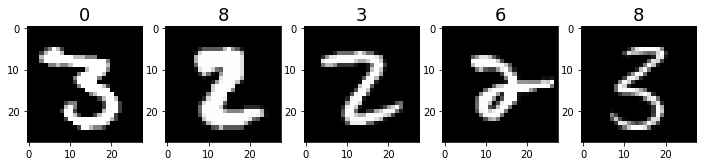

In [21]:
fit(hidden_do, train_images, train_labels, val_images, val_labels)

## Hidden + Data Augumentation

In [34]:
hidden_aug = Sequential([
    # Preprocess
    Flatten(input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    BatchNormalization(),
    
    # Input layer
    Dense(32),
    Activation('relu'),
    BatchNormalization(),
    
    # Hidden layer
    Dense(16),
    Activation('relu'),
    BatchNormalization(),
    
    # Output layer
    Dense(10),
    Activation('softmax'),
])

aug = ImageDataGenerator(
    rotation_range=10,
    zoom_range=(0.9, 1.2),
    data_format='channels_first',
)

hidden_aug.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_11 (Flatten)         (None, 784)               0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 784)               3136      
_________________________________________________________________
dense_26 (Dense)             (None, 32)                25120     
_________________________________________________________________
activation_26 (Activation)   (None, 32)                0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 32)                128       
_________________________________________________________________
dense_27 (Dense)             (None, 16)                528       
_________________________________________________________________
activation_27 (Activation)   (None, 16)                0         
__________

Epoch 1/5
25/25 [==============================] - 0s - loss: 0.4115 - acc: 0.8938 - val_loss: 0.4817 - val_acc: 0.8600
Epoch 2/5
25/25 [==============================] - 0s - loss: 0.3542 - acc: 0.9075 - val_loss: 0.4843 - val_acc: 0.8700
Epoch 3/5
25/25 [==============================] - 0s - loss: 0.3369 - acc: 0.9037 - val_loss: 0.4711 - val_acc: 0.8900
Epoch 4/5
25/25 [==============================] - 0s - loss: 0.3225 - acc: 0.9138 - val_loss: 0.4528 - val_acc: 0.8800
Epoch 5/5
25/25 [==============================] - 0s - loss: 0.3135 - acc: 0.9088 - val_loss: 0.4693 - val_acc: 0.8500
Epoch 1/10
25/25 [==============================] - 0s - loss: 0.3180 - acc: 0.9025 - val_loss: 0.5047 - val_acc: 0.8500
Epoch 2/10
25/25 [==============================] - 0s - loss: 0.2932 - acc: 0.9012 - val_loss: 0.5200 - val_acc: 0.8600
Epoch 3/10
25/25 [==============================] - 0s - loss: 0.2656 - acc: 0.9300 - val_loss: 0.4807 - val_acc: 0.8800
Epoch 4/10
25/25 [===================

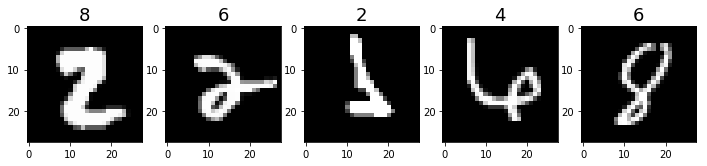

In [36]:
fit(hidden_aug, train_images, train_labels, val_images, val_labels, gen=aug)

## Convolution

In [54]:
conv = Sequential([
    BatchNormalization(axis=1, input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(axis=1),

    Flatten(),
    Dense(10, activation='softmax'),
])

conv.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_73 (Batc (None, 1, 28, 28)         4         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 32, 28, 28)        320       
_________________________________________________________________
batch_normalization_74 (Batc (None, 32, 28, 28)        128       
_________________________________________________________________
flatten_24 (Flatten)         (None, 25088)             0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)                250890    
Total params: 251,342
Trainable params: 251,276
Non-trainable params: 66
_________________________________________________________________


Epoch 1/5
25/25 [==============================] - 1s - loss: 2.4983 - acc: 0.6425 - val_loss: 0.9520 - val_acc: 0.6850
Epoch 2/5
25/25 [==============================] - 1s - loss: 0.6994 - acc: 0.8837 - val_loss: 0.7022 - val_acc: 0.7350
Epoch 3/5
25/25 [==============================] - 1s - loss: 0.1881 - acc: 0.9612 - val_loss: 0.5352 - val_acc: 0.8450
Epoch 4/5
25/25 [==============================] - 1s - loss: 0.1024 - acc: 0.9800 - val_loss: 0.6474 - val_acc: 0.7850
Epoch 5/5
25/25 [==============================] - 1s - loss: 0.0360 - acc: 0.9925 - val_loss: 0.4662 - val_acc: 0.8550
Epoch 1/10
25/25 [==============================] - 1s - loss: 0.0267 - acc: 0.9962 - val_loss: 0.4840 - val_acc: 0.8350
Epoch 2/10
25/25 [==============================] - 1s - loss: 0.0263 - acc: 0.9962 - val_loss: 0.4386 - val_acc: 0.8650
Epoch 3/10
25/25 [==============================] - 1s - loss: 0.0025 - acc: 1.0000 - val_loss: 0.4143 - val_acc: 0.8600
Epoch 4/10
25/25 [===================

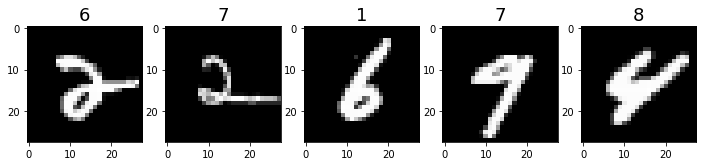

In [55]:
fit(conv, train_images, train_labels, val_images, val_labels)

## Deep Convolution

In [58]:
conv_deep = Sequential([
    BatchNormalization(axis=1, input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(axis=1),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    
    Flatten(),
    Dense(10, activation='softmax'),
])

conv_deep.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_78 (Batc (None, 1, 28, 28)         4         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 28, 28)        320       
_________________________________________________________________
batch_normalization_79 (Batc (None, 32, 28, 28)        128       
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 28, 28)        9248      
_________________________________________________________________
batch_normalization_80 (Batc (None, 32, 28, 28)        128       
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 32, 14, 14)        0         
_________________________________________________________________
flatten_26 (Flatten)         (None, 6272)              0         
__________

Epoch 1/5
25/25 [==============================] - 4s - loss: 1.4159 - acc: 0.6362 - val_loss: 0.9274 - val_acc: 0.6450
Epoch 2/5
25/25 [==============================] - 4s - loss: 0.3211 - acc: 0.9163 - val_loss: 0.7076 - val_acc: 0.8300
Epoch 3/5
25/25 [==============================] - 4s - loss: 0.0872 - acc: 0.9775 - val_loss: 0.8617 - val_acc: 0.7350
Epoch 4/5
25/25 [==============================] - 4s - loss: 0.0472 - acc: 0.9925 - val_loss: 0.9247 - val_acc: 0.7100
Epoch 5/5
25/25 [==============================] - 4s - loss: 0.0332 - acc: 0.9975 - val_loss: 1.0908 - val_acc: 0.6450
Epoch 1/10
25/25 [==============================] - 4s - loss: 0.0277 - acc: 0.9988 - val_loss: 1.1441 - val_acc: 0.6250
Epoch 2/10
25/25 [==============================] - 4s - loss: 0.0249 - acc: 0.9988 - val_loss: 1.1132 - val_acc: 0.6400
Epoch 3/10
25/25 [==============================] - 4s - loss: 0.0440 - acc: 0.9975 - val_loss: 1.0742 - val_acc: 0.6700
Epoch 4/10
25/25 [===================

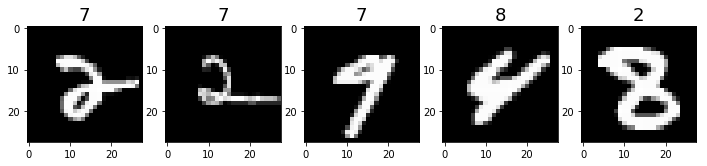

In [59]:
fit(conv_deep, train_images, train_labels, val_images, val_labels)

## Deep Convolution + Dropout

In [52]:
conv_deep_do = Sequential([
    BatchNormalization(axis=1, input_shape=(1, IMAGE_SIZE, IMAGE_SIZE)),
    
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(axis=1),
    Dropout(0.25),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D(),
    Dropout(0.5),
    
    Flatten(),
    Dense(10, activation='softmax'),
])

conv_deep_do.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_70 (Batc (None, 1, 28, 28)         4         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 28, 28)        320       
_________________________________________________________________
batch_normalization_71 (Batc (None, 32, 28, 28)        128       
_________________________________________________________________
dropout_33 (Dropout)         (None, 32, 28, 28)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 32, 28, 28)        9248      
_________________________________________________________________
batch_normalization_72 (Batc (None, 32, 28, 28)        128       
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 32, 14, 14)        0         
__________

Epoch 1/5
25/25 [==============================] - 5s - loss: 2.0932 - acc: 0.5363 - val_loss: 0.8663 - val_acc: 0.7500A: 1s - loss: 2.4255 - acc
Epoch 2/5
25/25 [==============================] - 5s - loss: 0.7432 - acc: 0.8087 - val_loss: 0.7055 - val_acc: 0.8200
Epoch 3/5
25/25 [==============================] - 5s - loss: 0.4920 - acc: 0.8700 - val_loss: 0.7250 - val_acc: 0.8000
Epoch 4/5
25/25 [==============================] - 5s - loss: 0.4046 - acc: 0.8862 - val_loss: 0.6906 - val_acc: 0.8100
Epoch 5/5
25/25 [==============================] - 5s - loss: 0.3417 - acc: 0.8925 - val_loss: 0.7356 - val_acc: 0.7600
Epoch 1/10
25/25 [==============================] - 5s - loss: 0.2693 - acc: 0.9250 - val_loss: 0.6173 - val_acc: 0.7900
Epoch 2/10
25/25 [==============================] - 5s - loss: 0.1360 - acc: 0.9537 - val_loss: 0.5771 - val_acc: 0.8250
Epoch 3/10
25/25 [==============================] - 5s - loss: 0.1574 - acc: 0.9525 - val_loss: 0.5459 - val_acc: 0.8200
Epoch 4/10


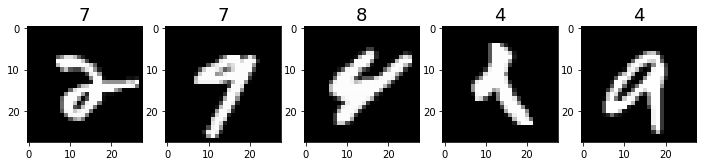

In [53]:
fit(conv_deep_do, train_images, train_labels, val_images, val_labels)